In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from statsmodels.tsa.stattools import adfuller, pacf, acf
import numpy as np
from numpy import polyfit
from scipy import stats
import RegscorePy as rp
from numpy import sqrt
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
import itertools

In [2]:
df = pd.read_csv('./data/RTS-history-USA.csv')
df = df[::-1]

In [3]:
series = np.array([i for i in df.Open[::25]])
series_dates = np.array([i for i in df.index[::25]])

In [82]:
draw = plt.plot

### Экспоненциальное сглаживание

In [4]:
def exponential_smoothing(series, alpha):
    result = np.array([series[0]]) # first value is same as series
    for n in range(1, len(series)):
        result = np.append(result, alpha * series[n] + (1 - alpha) * result[n-1])
    
    res = 0
    for s, r in zip(series, result):
        res += (s - r) ** 2
    return result

### Полином k-степени (поиск КФ тренда)

In [5]:
def get_polyfit(series, k, kf_out=False):
    p = polyfit(range(len(series)), series, k)
    if kf_out:
        for i in p:
            print(round(i, 4))
    return p

### Поиск самого тренда по КФ

In [6]:
def find_trend_by_kf(p, out=False):
    pf = np.poly1d(p)
    if out:
        print(pf(range(len(series))))
    return pf(range(len(series)))

### Поиск автокорреляции

In [7]:
def find_autocorr(seq, a=1, b=25):
    lags = []
    for lag in range(a, b+1):
        res_lag = pearsonr(seq[: -lag], seq[lag:])[0]
        lags.append(res_lag)
    return lags

### Сам график и сглаживания

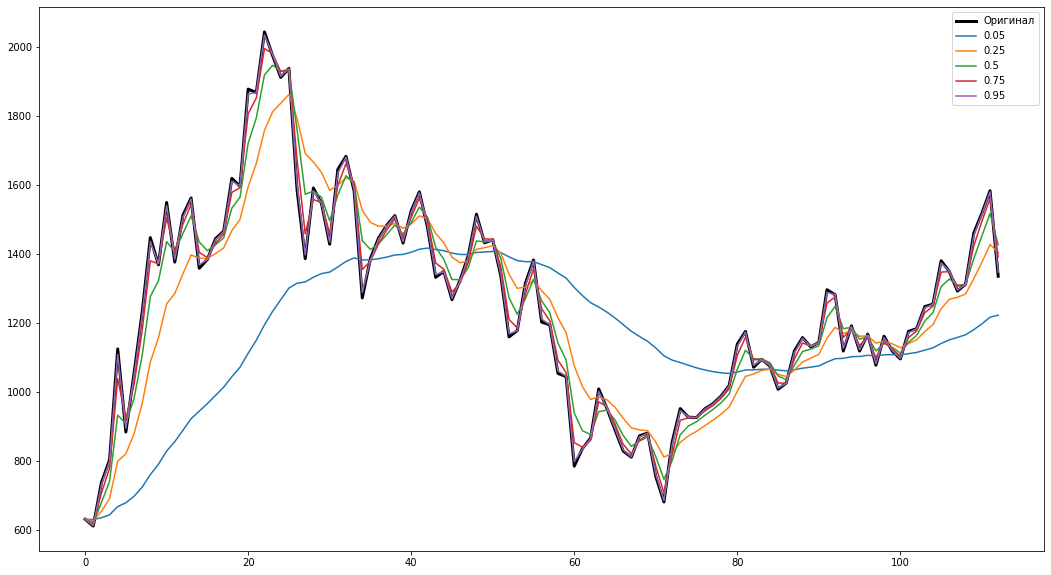

In [8]:
fig = plt.figure(figsize=(18, 10))
plt.plot(series, label='Оригинал', color='000', linewidth=3)
for a in [.05, .25, .5, .75, .95]:
    result = exponential_smoothing(series, a)
    plt.plot(result, label=str(a))
plt.legend()
plt.show()

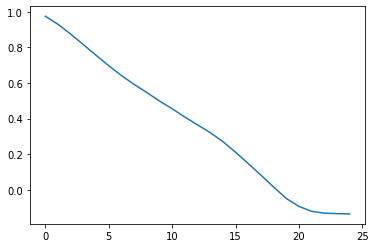

In [9]:
plt.plot(find_autocorr(exponential_smoothing(series, .5)));

### Тест фуллера

In [10]:
adfuller(series)

(-2.670316461994629,
 0.07931716496293206,
 0,
 112,
 {'1%': -3.4901313156261384,
  '5%': -2.8877122815688776,
  '10%': -2.5807296460459184},
 1212.2077258437034)

### Поиск и отображение тренда графика

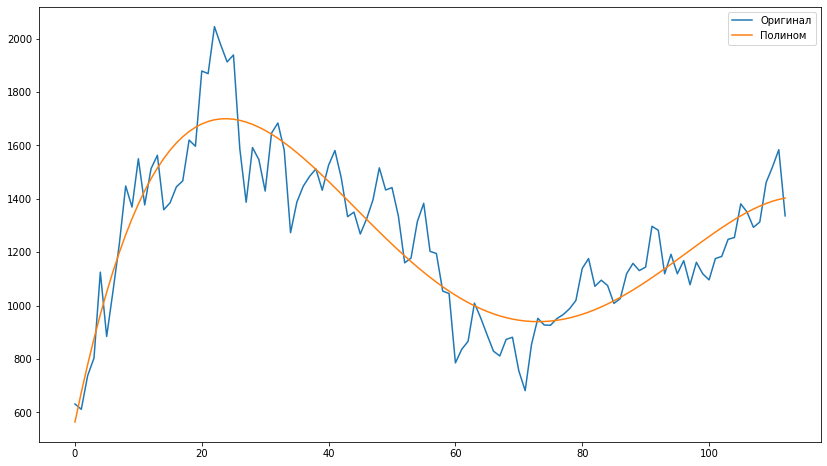

In [11]:
trend_line = find_trend_by_kf(get_polyfit(series, 4))
fig = plt.figure(figsize=(14, 8))
plt.plot(series, label='Оригинал')
plt.plot(trend_line, label='Полином')
plt.legend()
plt.show()

### Расчет КФ детерминации

In [12]:
pl = find_trend_by_kf(get_polyfit(series, 4))
mean = series.mean()

In [13]:
top = ((pl-mean)**2).sum()
bottom = ((series-mean)**2).sum()
kf_determ = top/bottom
kf_determ

0.805586569565061

### Скорректированный КФ детерм

In [14]:
kf_determ_adj = 1 - (1 - kf_determ)*((len(series)-1)/(len(series)-5))
kf_determ_adj

0.7983860721415448

### Значимость КФ автокорреляции 2-го порядка

In [15]:
kf2 = find_autocorr(exponential_smoothing(series, .5))[1]
kf2 / (1-kf2**2/(len(series)-2))**.5

0.9338383925415732

In [16]:
df3 = pd.read_csv('./data/RTS-history-USA.csv', parse_dates=True, index_col='Date')
df3 = df3[::-1][::25]
df3.head()

,Open
Date,
2009-01-11,631
2009-02-13,611
2009-03-24,737
2009-04-28,803
2009-06-04,1125


### Декомпозиция

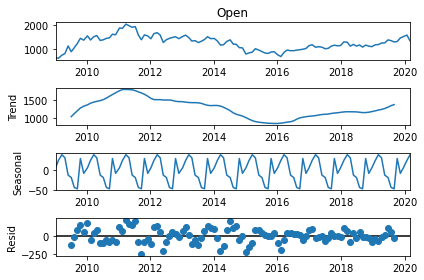

In [17]:
import statsmodels.api as sm

dta = df3.copy()
# deal with missing values. see issue
dta.Open.interpolate(inplace=True)

res = sm.tsa.seasonal_decompose(dta.Open, period=10)
res.plot();

### Нахождение остатков после вычитания тренда

In [18]:
remains = series - trend_line

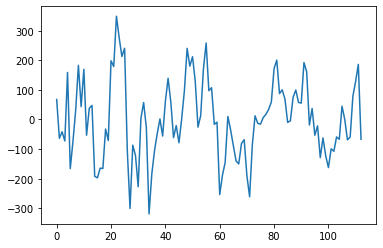

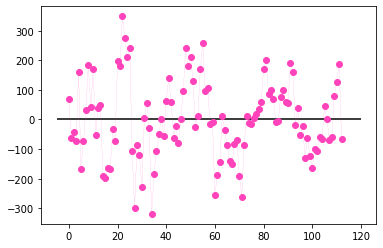

In [19]:
plt.plot(remains);
plt.show()
fig, ax = plt.subplots()
ax.plot(remains, marker='o', color='#f4b', linewidth=.1);
ax.hlines(0, -5, 120);

### Критерий Фишера для уравнения тренда 

In [20]:
(kf_determ/(1-kf_determ))*(len(series)-5)/4

111.87929419071503

## Значимость КФ регрессии по Стьюденту

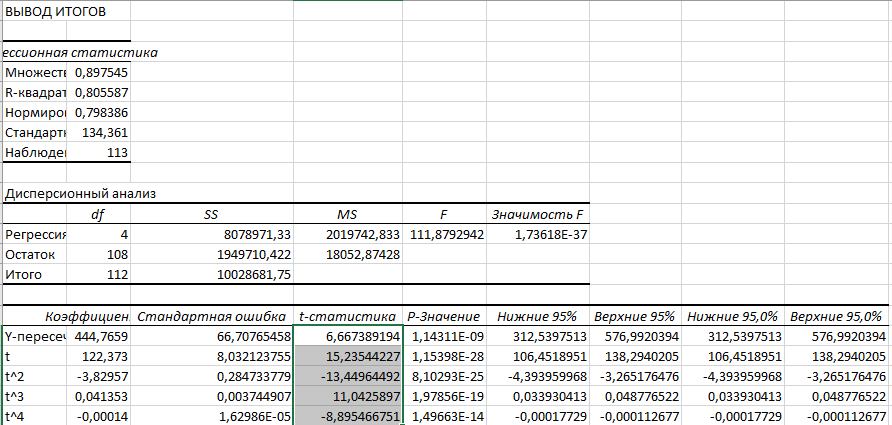

### Критерий Шварца

In [21]:
rp.bic.bic(series.tolist(), trend_line.tolist(), 5)/len(series)

9.964980051513505

In [22]:
np.log((remains ** 2).sum()/len(series))+5 * np.log(len(series))/len(series)

9.964980051513505

### Критерий Акаике

In [23]:
rp.aic.aic(series.tolist(), trend_line.tolist(), 5)/len(series)

9.84429917457933

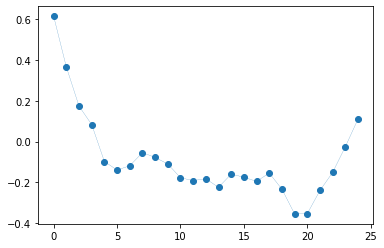

In [24]:
plt.plot(find_autocorr(remains), marker='o', linewidth=.2);

### Критерий Жакка-Бера на нормальность распределения

In [25]:
stats.jarque_bera(remains)

(0.5095735668305718, 0.7750817406258271)

### РС критерий на нормальность распределения

In [26]:
(remains.max() - remains.min()) / ((remains**2).sum()/len(series)-1)**.5

5.085495701916399

### Тест Дарбина Уотсона на автокорреляцию

In [27]:
# Сравнить с таблицей!

In [28]:
dw = 0
for t in range(1, len(remains)):
    dw += (remains[t]-remains[t-1])**2
dw /= (remains**2).sum()
dw

0.7705080573236872

### Тест на значимость КФ автокорреляции

In [29]:
kf = find_autocorr(remains, 1, 1)[0]
sqrt((kf**2)/(1-kf**2)*(len(remains)-2))

8.193201354824389

### Тест на равенство средних

In [30]:
stats.ttest_ind(series[:60], series[60:])

Ttest_indResult(statistic=6.430267317147217, pvalue=3.3086141740613716e-09)

In [31]:
# Поскольку у нас p-value очень мало, то гипотеза h0 - о равенстве средних отвергается

In [32]:
p1 = remains[:55]
p2 = remains[55:]
abs(p1.mean() - p2.mean()) / sqrt(np.var(p1)/len(p1) + np.var(p2)/len(p2))

0.7148925714768324

### ARIMA

1 1 1 12.122225128614922
(1, 1, 1) 12.122225128614922


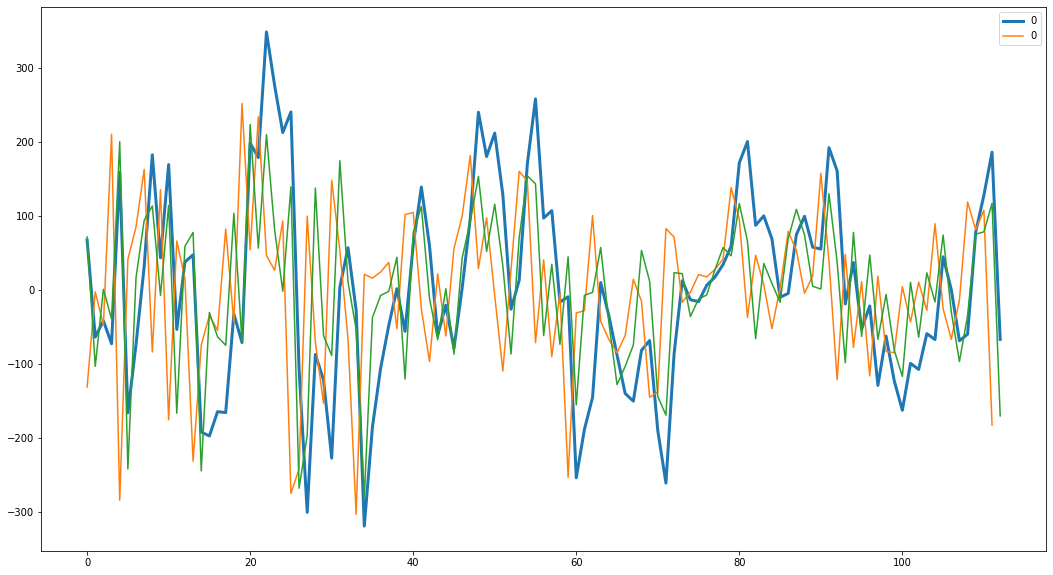

In [71]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(remains, label='Orig', linewidth=3)

min_aic = float('inf')
min_param = ()
min_mfit = None
# 7 0 2 
# for p, d, q in itertools.product((1, 5), (0, 1, 2), (1, 2, 6, 7)):
for p, d, q in ((1,1,1),):
    try:
        model = ARIMA(remains, order=(p, d, q))
        mfit = model.fit()
        aic_r = mfit.aic / len(remains)
    except:
        pass
    else:
        print(p, d, q, aic_r)
        if aic_r < min_aic:
            min_aic = aic_r
            min_param = p, d, q
            min_mfit = mfit
print(min_param, min_aic)
pd.DataFrame(mfit.resid).plot(ax=ax)
model = ARIMA(remains, order=(7, 0, 2))
mfit = model.fit()
pd.DataFrame(mfit.resid).plot(ax=ax)
plt.show()

In [74]:
mfit.resid

array([  71.8009365 , -103.05510899,    1.03573409,  -39.11195075,
        200.46612406, -241.8074504 ,   16.79936547,   94.23147915,
        113.68871265,   -7.27193265,  114.39443434, -166.44758062,
         59.16805292,   77.89672986, -244.4926355 ,  -30.27615482,
        -63.16056826,  -74.69118162,  103.77599448,  -70.10374257,
        223.68745385,   56.71806962,  209.9925607 ,   81.47057716,
         -1.65493687,  139.63208039, -267.93074018, -196.22479402,
        137.84884614,  -61.57275415,  -88.41855686,  174.77586862,
         11.2845192 ,  -53.44421272, -280.10918818,  -37.11864516,
         -7.31625334,   -1.82890113,   44.38118344, -120.28336661,
         77.79418373,  112.92988263,  -11.17437944,  -67.18705018,
          1.8242796 ,  -86.66753676,   43.13537028,   92.82863319,
        153.61098453,   52.19684675,  115.95799199,   32.13336646,
        -86.38596391,   70.40106124,  154.38256689,  143.53518471,
        -61.51814822,   34.79835187,  -73.42830869,   44.94109

In [76]:
mfit.arparams

array([ 2.14014188, -1.90444791,  0.52386701,  0.26417115, -0.54254111,
        0.54319074, -0.25262163])

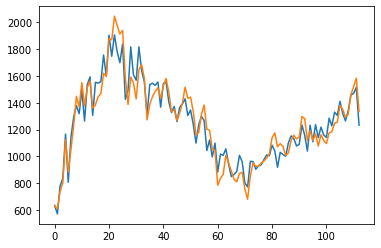

In [86]:
draw(trend_line + mfit.resid);
draw(series);

#### p - 1,5

#### q - 1,2,6,7

/home/utoo/.venv_wrappers/maxim/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/home/utoo/.venv_wrappers/maxim/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


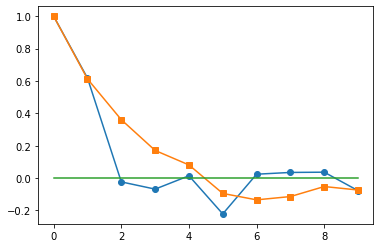

In [60]:
plt.plot(pacf(remains)[:10], marker='o', label='PACF');
plt.plot(acf(remains)[:10], marker='s');
plt.plot([0]*10)
plt.show();